# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [46]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [47]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

Traceback (most recent call last):
  File "/Users/prokhorovartem/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/Users/prokhorovartem/opt/anaconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/prokhorovartem/opt/anaconda3/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/Users/prokhorovartem/opt/anaconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


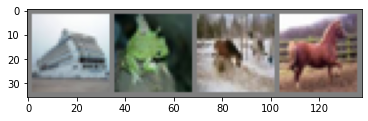

ship frog horse horse


In [48]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [49]:
im_size = images[:1].shape[2]
out_features = torch.unique(labels).shape[0]

print(im_size, out_features)

32 10


In [50]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
        )
        
        self.base = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        
        self.head = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=8),
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=10)
        )

    def forward(self, x):
        out1 = self.encoder(x)
        out2 = self.base(x)
        out = self.head(out1 + out2)
        return out

In [51]:
net = BasicBlockNet()
net

BasicBlockNet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (base): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (head): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

Проверим, что выход сети имеет корректную размерность:

In [52]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [53]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [54]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [55]:
from tqdm.notebook import tqdm

In [57]:
def test(model, criterion, loader, desc):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in tqdm(loader, desc=desc):
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
            logits = model(data)
            loss = criterion(logits, target)

        loss_log.append(loss.item())
        acc = (logits.argmax(dim=1) == target).sum().item() / len(target)
        acc_log.append(acc) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, criterion, train_loader, desc):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in tqdm(train_loader, desc=desc):
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        acc = (logits.argmax(dim=1) == target).sum().item() / len(target)
        acc_log.append(acc)

    return loss_log, acc_log

def train(model, optimizer, criterion, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    
    for epoch in range(n_epochs):
        desc_train=f'Training {epoch}/{n_epochs}'
        train_loss, train_acc = train_epoch(model, optimizer, criterion, train_loader, desc_train)
        desc_test=f'Testing {epoch}/{n_epochs}'
        val_loss, val_acc = test(model, criterion, val_loader, desc_test)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, 20, train_loader, val_loader)

Training 0/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 0/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.4518099355305352, train acc: 0.48546454687908064
 val loss: 1.1986855377542212, val acc: 0.5738031914893617



Training 1/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 1/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.136976265929081, train acc: 0.6037354727082789
 val loss: 1.0853462789921051, val acc: 0.6239361702127659



Training 2/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 2/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.0325576174847604, train acc: 0.6390049621311047
 val loss: 1.0591226519422328, val acc: 0.6327349290780141



Training 3/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 3/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 0.9864314583145504, train acc: 0.6566417471924785
 val loss: 1.0582306608240655, val acc: 0.6335106382978724



Training 4/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 4/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.9507377436435637, train acc: 0.6709201162183337
 val loss: 0.9995246889743399, val acc: 0.6558510638297872



Training 5/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 5/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.9300700853250145, train acc: 0.6779185165839644
 val loss: 0.9687362949898902, val acc: 0.6691489361702128



Training 6/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 6/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.9041156969297085, train acc: 0.6861452076260119
 val loss: 1.0085018005776913, val acc: 0.6570035460992907



Training 7/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 7/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.8888623454562053, train acc: 0.6899076129537738
 val loss: 0.9712267878207754, val acc: 0.6702127659574468



Training 8/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 8/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.8704047832890011, train acc: 0.697530360407417
 val loss: 0.9520499954832361, val acc: 0.6718306737588652



Training 9/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 9/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.8554807947693185, train acc: 0.7017008357273439
 val loss: 0.9303516334675728, val acc: 0.680363475177305



Training 10/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 10/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.8419977789387189, train acc: 0.7070261491250979
 val loss: 0.9102128848116449, val acc: 0.6888297872340425



Training 11/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 11/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.8313537442161134, train acc: 0.7116577435361714
 val loss: 0.8932888178115196, val acc: 0.6954565602836881



Training 12/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 12/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.8225362090567566, train acc: 0.71452239488117
 val loss: 0.9197686956283894, val acc: 0.6876329787234042



Training 13/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 13/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.8116505266979364, train acc: 0.7202068098720292
 val loss: 0.9113170164696713, val acc: 0.6886081560283689



Training 14/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 14/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.8041883928793222, train acc: 0.7213983742491512
 val loss: 0.883946586162486, val acc: 0.6981161347517731



Training 15/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 15/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.7975294593265331, train acc: 0.7248465656829459
 val loss: 0.8960026094254027, val acc: 0.6902703900709221



Training 16/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 16/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.7886339556800382, train acc: 0.7255974144685297
 val loss: 0.9008155878554, val acc: 0.692575354609929



Training 17/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 17/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.7759479298996969, train acc: 0.7318123204492034
 val loss: 0.916458941013255, val acc: 0.6927304964539008



Training 18/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 18/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.7697138383684908, train acc: 0.7336608775137111
 val loss: 0.9613008027381086, val acc: 0.676595744680851



Training 19/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 19/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.7639848250466683, train acc: 0.7341505615043091
 val loss: 0.8855359468054265, val acc: 0.6950576241134753



Посчитайте точность на тестовой выборке:

In [63]:
test(net, criterion, test_loader, 'Testing')[1:2]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

(0.6880971337579618,)

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.


**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 15, 7
plt.rcParams['font.size'] = 20
sns.set(style='darkgrid')

In [88]:
diff = len(train_loss_log) / len(val_loss_log)

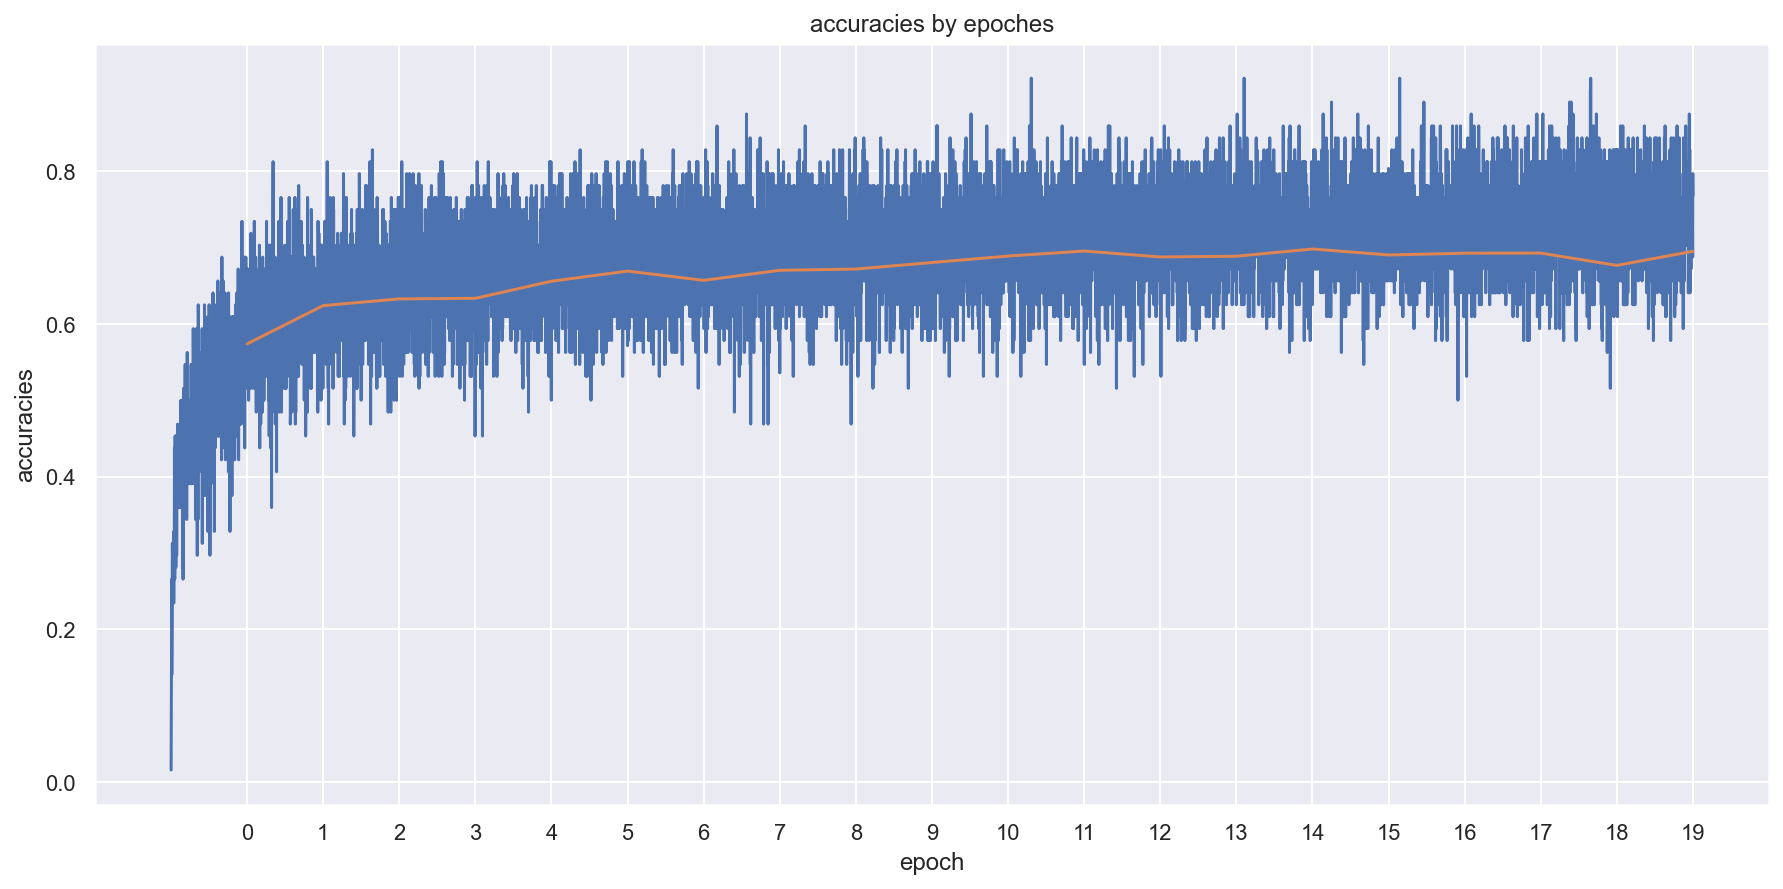

In [92]:
plt.plot(np.arange(1, len(train_acc_log) + 1), train_acc_log)
plt.plot(np.arange(1, len(val_acc_log) + 1) * diff, val_acc_log)
plt.xticks(np.arange(1, len(val_acc_log) + 1) * diff, np.arange(len(val_acc_log)))
plt.ylabel('accuracies')
plt.xlabel('epoch')
plt.title('accuracies by epoches')

plt.show()

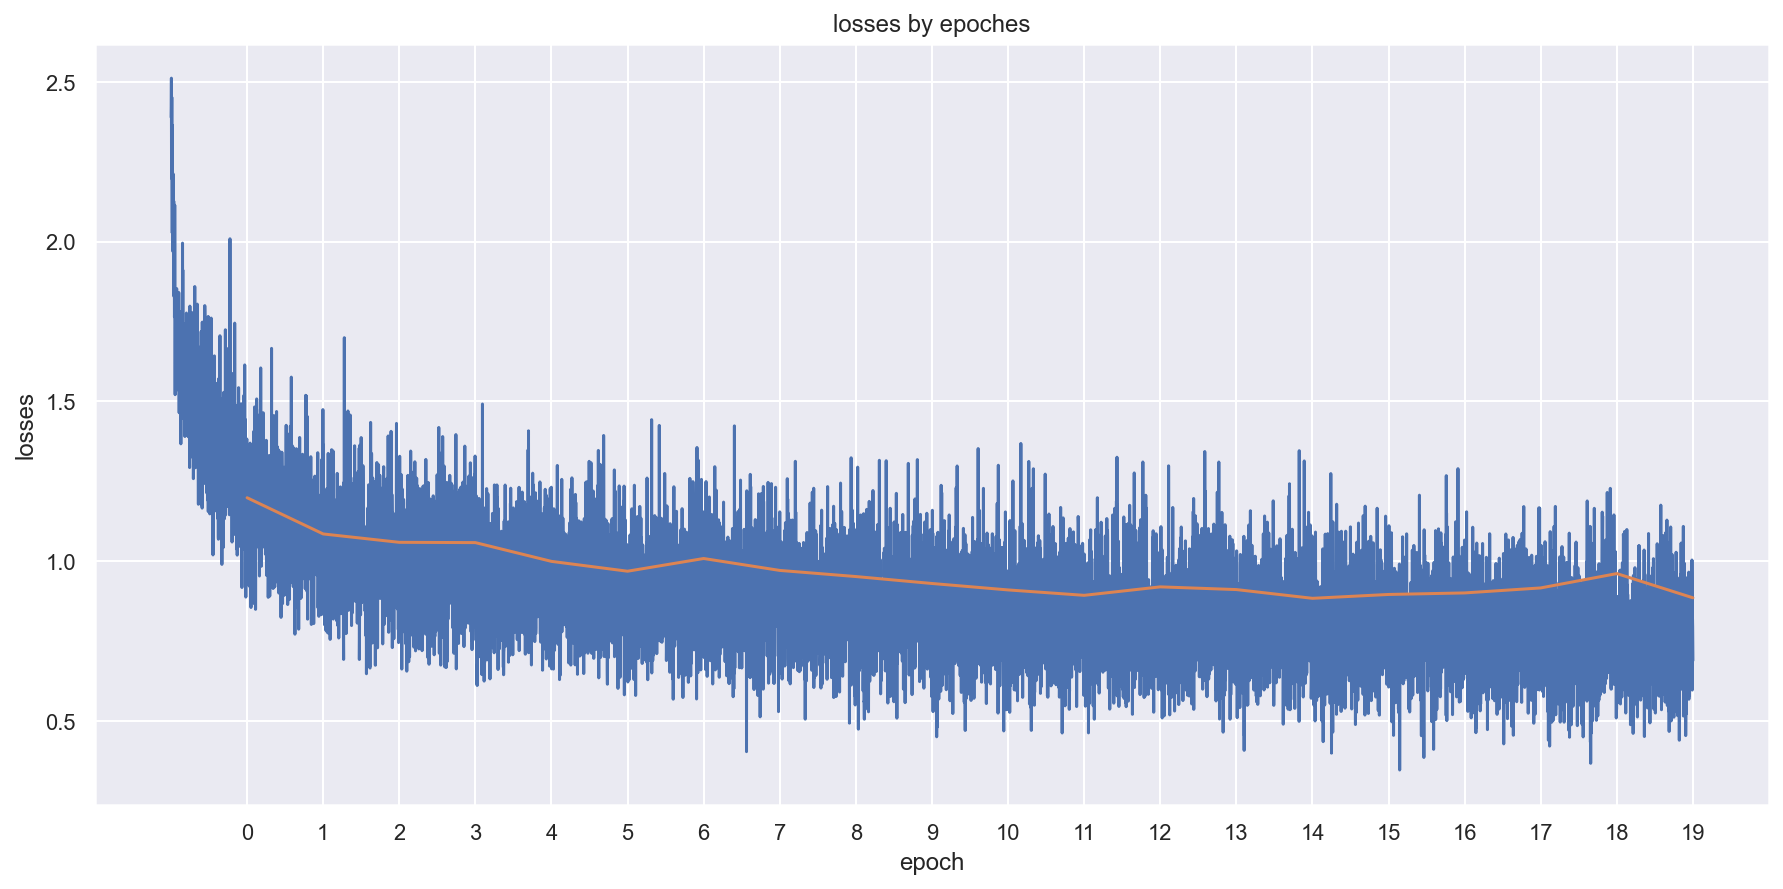

In [93]:
plt.plot(np.arange(1, len(train_loss_log) + 1), train_loss_log)
plt.plot(np.arange(1, len(val_loss_log) + 1) * diff, val_loss_log)
plt.xticks(np.arange(1, len(val_loss_log) + 1) * diff, np.arange(len(val_loss_log)))
plt.ylabel('losses')
plt.xlabel('epoch')
plt.title('losses by epoches')

plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [94]:
criterion = nn.CrossEntropyLoss()
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, 20, train_loader, val_loader, scheduler)

Training 0/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 0/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.5020406965363833, train acc: 0.4643183598850875
 val loss: 1.2833874238298295, val acc: 0.5430186170212766



Training 1/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 1/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.1858069503329136, train acc: 0.5847479759728389
 val loss: 1.1522896530780387, val acc: 0.5890514184397162



Training 2/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 2/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.0724137886350726, train acc: 0.6253305366936537
 val loss: 1.0494245762520649, val acc: 0.639450354609929



Training 3/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 3/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.0082841243124967, train acc: 0.6498065748237138
 val loss: 0.9902858130475308, val acc: 0.6509751773049646



Training 4/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 4/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.962043262268987, train acc: 0.6662150692086707
 val loss: 0.9776660665552667, val acc: 0.6629875886524822



Training 5/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 5/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.933353626967784, train acc: 0.6760005876207887
 val loss: 0.9919286979005691, val acc: 0.6596631205673759



Training 6/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 6/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.9104455174432158, train acc: 0.6840518085662053
 val loss: 0.9190038318329669, val acc: 0.6859929078014183



Training 7/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 7/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.883674915900396, train acc: 0.694575933664142
 val loss: 0.9049008539382447, val acc: 0.6879432624113476



Training 8/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 8/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.8680344150968617, train acc: 0.7008561308435622
 val loss: 0.8708708856968169, val acc: 0.701063829787234



Training 9/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 9/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.8437872347055885, train acc: 0.7098663162705667
 val loss: 0.9358655105245874, val acc: 0.6815824468085107



Training 10/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 10/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.7379074368550965, train acc: 0.7474169169495951
 val loss: 0.8172872505289444, val acc: 0.7196808510638298



Training 11/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 11/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.7216058931359425, train acc: 0.753431868634108
 val loss: 0.8116526225779919, val acc: 0.722406914893617



Training 12/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 12/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.7143349107048411, train acc: 0.7541827174196919
 val loss: 0.8229820626847287, val acc: 0.7189716312056736



Training 13/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 13/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.7092665686140984, train acc: 0.7575125685557587
 val loss: 0.8026828129240807, val acc: 0.7257313829787234



Training 14/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 14/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.7066870096396702, train acc: 0.7594672238182293
 val loss: 0.8134715708012277, val acc: 0.7233156028368796



Training 15/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 15/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.69074033677469, train acc: 0.765975940193262
 val loss: 0.7987902274791231, val acc: 0.7278590425531914



Training 16/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 16/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.6875097322289643, train acc: 0.7659963436928702
 val loss: 0.7980959726140854, val acc: 0.7281914893617021



Training 17/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 17/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.687678434077303, train acc: 0.7648823126142597
 val loss: 0.7990056398067068, val acc: 0.7283244680851064



Training 18/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 18/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.6868704854897215, train acc: 0.765041459911204
 val loss: 0.7977807096978451, val acc: 0.727593085106383



Training 19/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 19/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.6859880740289497, train acc: 0.7668818555758684
 val loss: 0.7972458339752035, val acc: 0.728125



Посчитайте точность на тестовой выборке:

In [95]:
test(net, criterion, test_loader, 'Testing')[1:2]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

(0.7173566878980892,)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [96]:
criterion = nn.CrossEntropyLoss()
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, 20, train_loader, val_loader)

Training 0/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 0/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.8298516157994105, train acc: 0.362925208931836
 val loss: 1.6198955175724434, val acc: 0.43927304964539005



Training 1/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 1/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.5425263889528933, train acc: 0.46238410812222513
 val loss: 1.471346358035473, val acc: 0.4808510638297872



Training 2/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 2/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.4308715740549063, train acc: 0.49632737007051453
 val loss: 1.3821705939921927, val acc: 0.5137854609929079



Training 3/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 3/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.3693771434222541, train acc: 0.5201464155131889
 val loss: 1.3351089406520762, val acc: 0.5271719858156029



Training 4/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 4/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 1.3210680721228911, train acc: 0.5349185492295638
 val loss: 1.3010756046214003, val acc: 0.536613475177305



Training 5/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 5/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 1.283231519366967, train acc: 0.54981718464351
 val loss: 1.2614917280826163, val acc: 0.553125



Training 6/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 6/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 1.2504184106586185, train acc: 0.5610023831287542
 val loss: 1.2413639025485261, val acc: 0.5659352836879433



Training 7/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 7/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 1.2194870631917085, train acc: 0.5724283429093758
 val loss: 1.1968192267925182, val acc: 0.5808289007092199



Training 8/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 8/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 1.187482825580855, train acc: 0.5848948811700183
 val loss: 1.1633593551656034, val acc: 0.5893173758865248



Training 9/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 9/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 1.1609029159685376, train acc: 0.5943906698876992
 val loss: 1.1331579779056793, val acc: 0.6036569148936171



Training 10/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 10/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 1.1311909319931672, train acc: 0.6031478519195612
 val loss: 1.117672163882154, val acc: 0.607247340425532



Training 11/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 11/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 1.1032581629003424, train acc: 0.6146105379994776
 val loss: 1.0806590435352732, val acc: 0.6217198581560285



Training 12/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 12/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 1.0757610720515904, train acc: 0.6238492426220945
 val loss: 1.071495142388851, val acc: 0.625642730496454



Training 13/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 13/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 1.0510590512312308, train acc: 0.6367850613737268
 val loss: 1.0587737953409235, val acc: 0.6292331560283688



Training 14/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 14/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 1.0268807049425255, train acc: 0.6435263776442935
 val loss: 1.0452983544227925, val acc: 0.6371010638297873



Training 15/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 15/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 1.0074115067556964, train acc: 0.6497616871245757
 val loss: 1.0087482957129783, val acc: 0.6498448581560284



Training 16/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 16/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.9937066229867325, train acc: 0.6558704949072865
 val loss: 0.9803949401733724, val acc: 0.6591312056737588



Training 17/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 17/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.9732683075411446, train acc: 0.6644970945416558
 val loss: 0.9803821685466361, val acc: 0.6561835106382978



Training 18/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 18/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.9623859525816532, train acc: 0.6655295116218335
 val loss: 0.9550560332359151, val acc: 0.6673093971631204



Training 19/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 19/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.9495545875219802, train acc: 0.6709650039174718
 val loss: 1.0249891562664764, val acc: 0.6385416666666668



In [97]:
test(net, criterion, test_loader, 'Testing')[1:2]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

(0.6308718152866242,)

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

### StepLR

Умножает `lr` каждые `step_size` эпох на `gamma`

In [98]:
criterion = nn.CrossEntropyLoss()
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, 20, train_loader, val_loader, scheduler)

Training 0/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 0/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.453975095064592, train acc: 0.4799351984852442
 val loss: 1.1569689588343843, val acc: 0.5909574468085106



Training 1/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 1/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.1399589747571859, train acc: 0.5984387242099765
 val loss: 1.0490925228342096, val acc: 0.6292553191489362



Training 2/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 2/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.0396742973292767, train acc: 0.6378378819535127
 val loss: 1.0855658581916323, val acc: 0.627171985815603



Training 3/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 3/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 0.9831455505744194, train acc: 0.6576211151736746
 val loss: 0.9690695544506641, val acc: 0.6611480496453902



Training 4/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 4/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.8501034669401005, train acc: 0.7052061569600419
 val loss: 0.885264505224025, val acc: 0.6946586879432625



Training 5/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 5/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.8315600060348755, train acc: 0.7131227148080439
 val loss: 0.8772835893833891, val acc: 0.6997783687943263



Training 6/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 6/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.8209028280522314, train acc: 0.7170320253329852
 val loss: 0.8795385053817262, val acc: 0.6973182624113476



Training 7/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 7/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.8144292655984924, train acc: 0.7174564181248367
 val loss: 0.8732340624991883, val acc: 0.7000443262411349



Training 8/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 8/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.7937746307313769, train acc: 0.7268012209454167
 val loss: 0.8561938765201162, val acc: 0.7082225177304965



Training 9/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 9/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.7902580727388916, train acc: 0.727099112039697
 val loss: 0.8542980845938337, val acc: 0.707424645390071



Training 10/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 10/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.788724292566833, train acc: 0.72804583442152
 val loss: 0.8540672124700344, val acc: 0.7069592198581561



Training 11/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 11/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.7880263354704192, train acc: 0.7285844868111778
 val loss: 0.8535466506126079, val acc: 0.7073581560283688



Training 12/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 12/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.7858044560147378, train acc: 0.7296617915904936
 val loss: 0.8528439932681144, val acc: 0.7080230496453902



Training 13/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 13/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.7838071655529727, train acc: 0.7299270370854009
 val loss: 0.8526897478610911, val acc: 0.7069592198581561



Training 14/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 14/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.7842763265700401, train acc: 0.7292537215983286
 val loss: 0.8529472627538316, val acc: 0.7088209219858157



Training 15/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 15/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.7856590152331636, train acc: 0.7293475776965265
 val loss: 0.8525443173469381, val acc: 0.7078900709219859



Training 16/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 16/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.7849992196019433, train acc: 0.7308003068686342
 val loss: 0.8526815373846826, val acc: 0.7086879432624115



Training 17/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 17/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.784916188588308, train acc: 0.7309961804648734
 val loss: 0.8532052281055045, val acc: 0.7068262411347519



Training 18/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 18/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.7843778889619454, train acc: 0.7287599569078088
 val loss: 0.8526592072020186, val acc: 0.7077570921985816



Training 19/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 19/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.784439621775852, train acc: 0.728560002611648
 val loss: 0.8528493252206356, val acc: 0.7070257092198582



In [99]:
test(net, criterion, test_loader, 'Testing')[1:2]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

(0.7017316878980892,)

### LambdaLR

Умножает `lr` на `lr_lambda` 

In [100]:
criterion = nn.CrossEntropyLoss()
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
lambda1 = lambda epoch: 0.65 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, 20, train_loader, val_loader, scheduler)

Training 0/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 0/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.4787174669218675, train acc: 0.4725205667276051
 val loss: 1.2552570999936854, val acc: 0.5585549645390072



Training 1/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 1/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.1627086289839945, train acc: 0.5914648080438757
 val loss: 1.1684433166016923, val acc: 0.5851285460992907



Training 2/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 2/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.0305880295075271, train acc: 0.6369605314703578
 val loss: 1.0277800542242983, val acc: 0.64104609929078



Training 3/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 3/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 0.9578410187630593, train acc: 0.6668802232958997
 val loss: 0.955642961948476, val acc: 0.6673093971631204



Training 4/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 4/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.9064908551777521, train acc: 0.6860880778271089
 val loss: 0.9265154392161268, val acc: 0.6777482269503545



Training 5/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 5/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.8701028802059251, train acc: 0.6991871245756072
 val loss: 0.9268453270831006, val acc: 0.6772384751773051



Training 6/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 6/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.8487196668737331, train acc: 0.7063283494384957
 val loss: 0.8951225952899202, val acc: 0.6910017730496455



Training 7/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 7/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.8342642060581466, train acc: 0.7117924066335858
 val loss: 0.8874392055450602, val acc: 0.6923980496453902



Training 8/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 8/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.8222897801364362, train acc: 0.7149345455732568
 val loss: 0.8824880861221476, val acc: 0.6958998226950354



Training 9/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 9/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.8157073497445317, train acc: 0.7183256072081483
 val loss: 0.8787498697321465, val acc: 0.6982491134751774



Training 10/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 10/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.8101834034244146, train acc: 0.7206434447636458
 val loss: 0.8749703343878401, val acc: 0.6980274822695035



Training 11/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 11/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.8062867862759822, train acc: 0.7213902128493079
 val loss: 0.8728574336843288, val acc: 0.6979609929078013



Training 12/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 12/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.8041623271797431, train acc: 0.7230877840167146
 val loss: 0.8723603598614956, val acc: 0.6984264184397162



Training 13/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 13/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.802176667905159, train acc: 0.7231571559153825
 val loss: 0.8713925384460611, val acc: 0.6998226950354609



Training 14/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 14/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.8018187695273098, train acc: 0.7236876469051973
 val loss: 0.8713352058796172, val acc: 0.6997562056737587



Training 15/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 15/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.801047307372747, train acc: 0.7236182750065292
 val loss: 0.8708553385227285, val acc: 0.6997562056737587



Training 16/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 16/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.80107134831235, train acc: 0.723956973100026
 val loss: 0.8706701070704359, val acc: 0.6998891843971631



Training 17/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 17/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.8003688992377391, train acc: 0.7242426220945416
 val loss: 0.8723099881030144, val acc: 0.6982047872340426



Training 18/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 18/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.7995687456192002, train acc: 0.724426253591016
 val loss: 0.8705772739775637, val acc: 0.7004875886524822



Training 19/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 19/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.7997008477639018, train acc: 0.7234224014102899
 val loss: 0.871027627143454, val acc: 0.6998226950354609



Тут я забыл вывести точность на тесте, но, судя по точности на валидации, там не будет особо крутого результата(

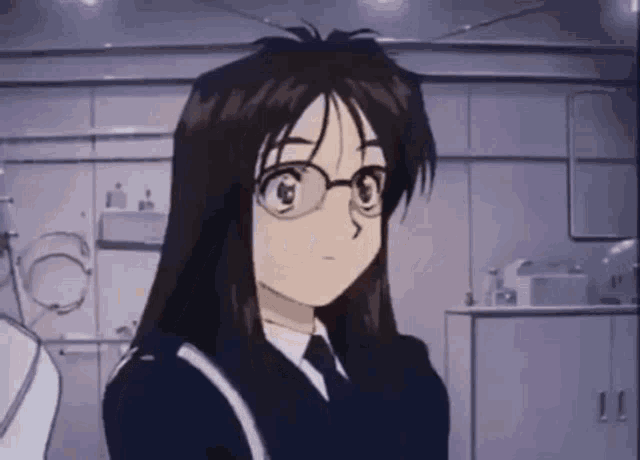

In [123]:
from IPython.display import Image
Image(filename='ah-eto-bleh-anime.gif')

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

Посмотрим, на преобразования, которые мы будем(мб) использовать в `transformer`

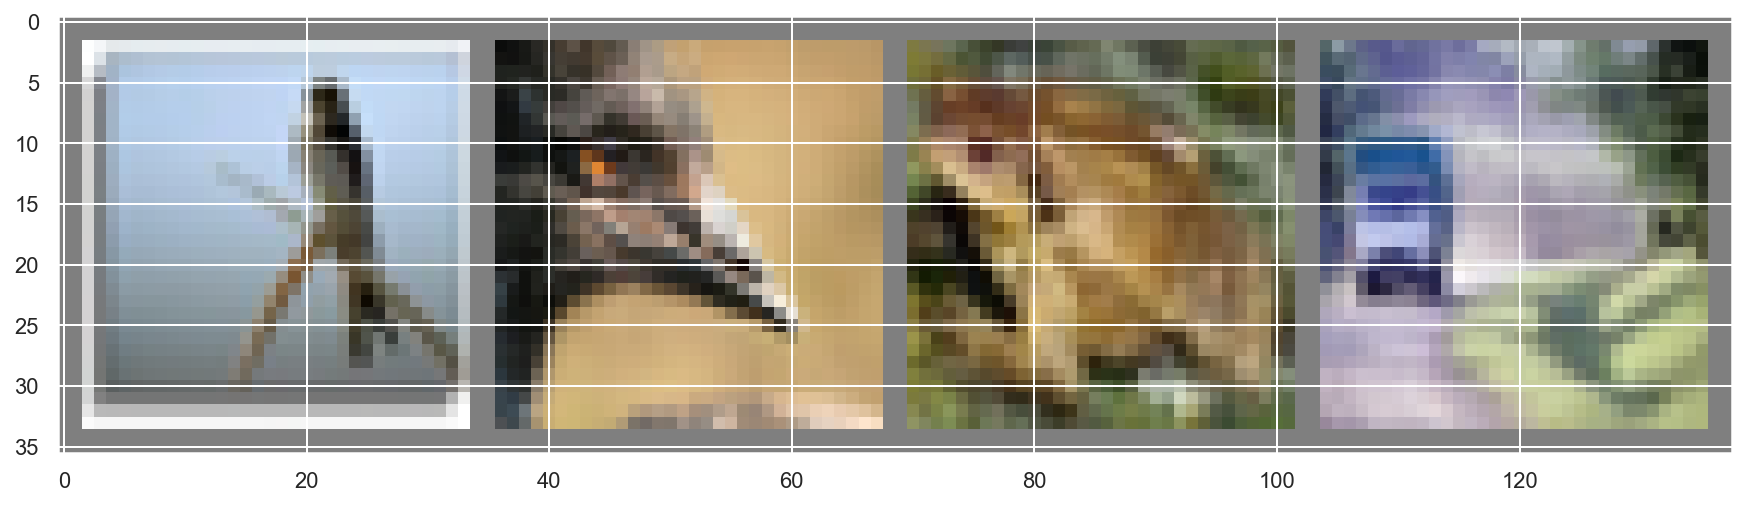

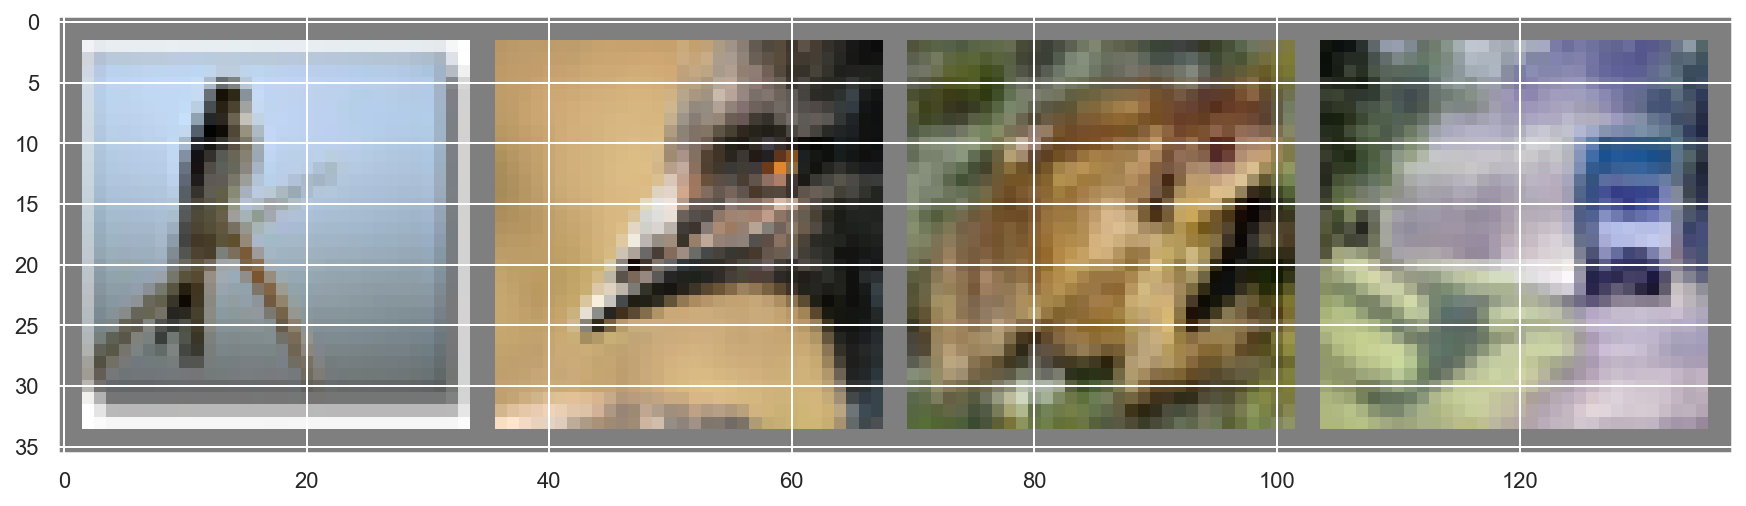

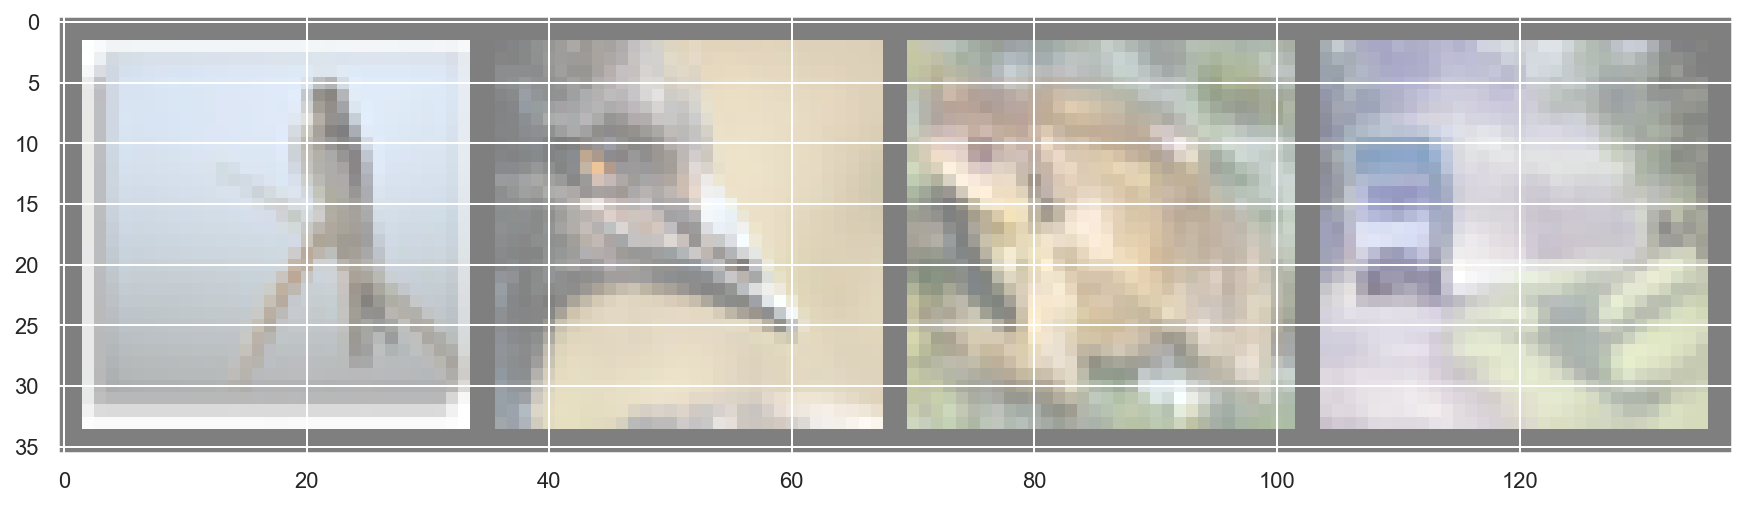

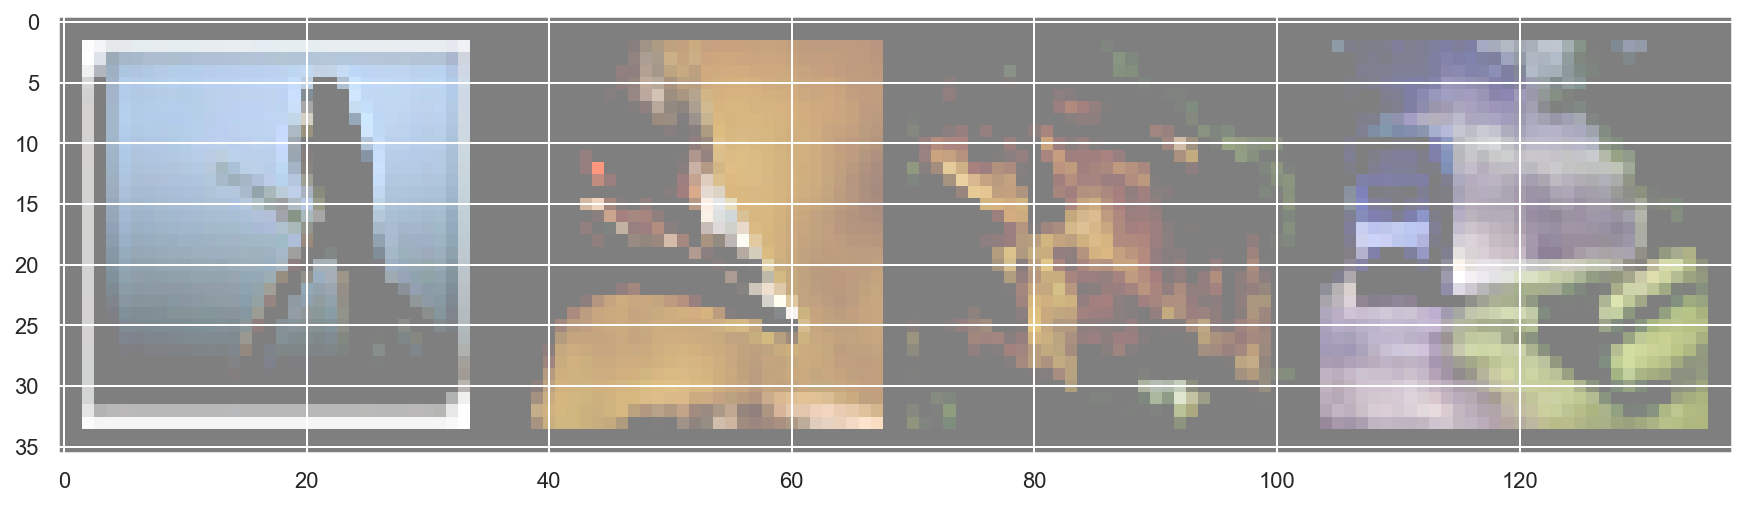

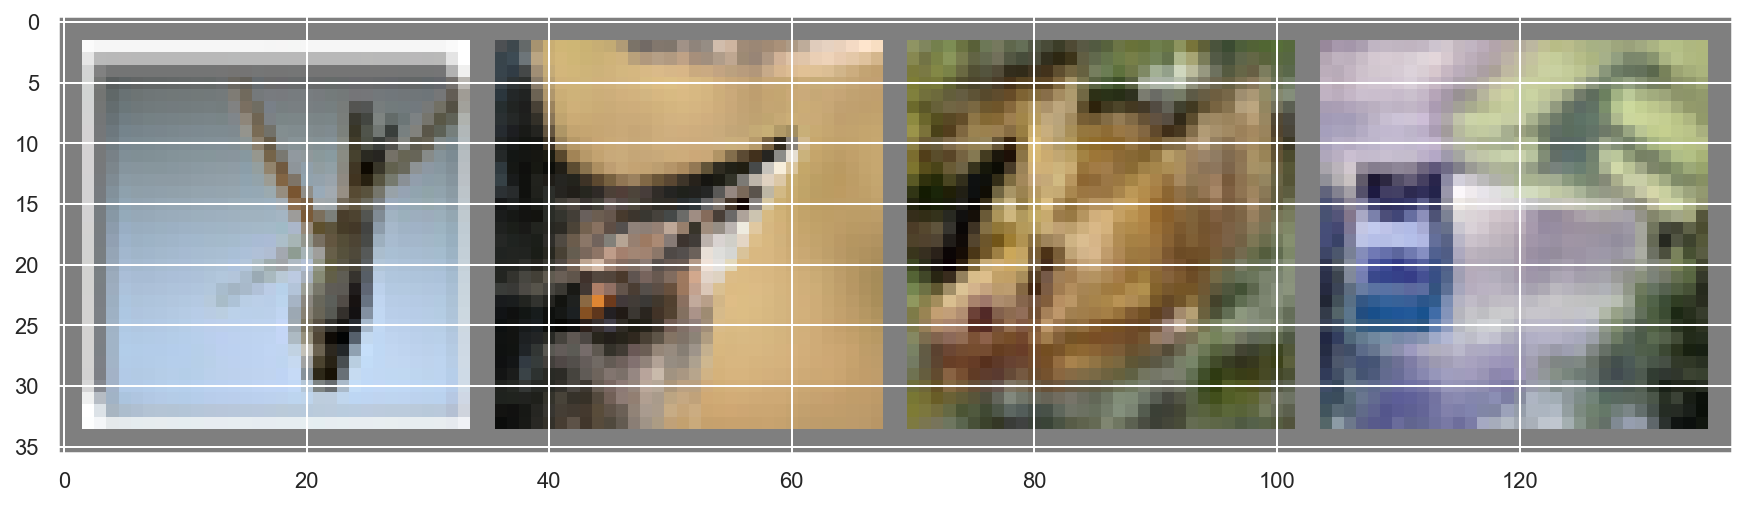

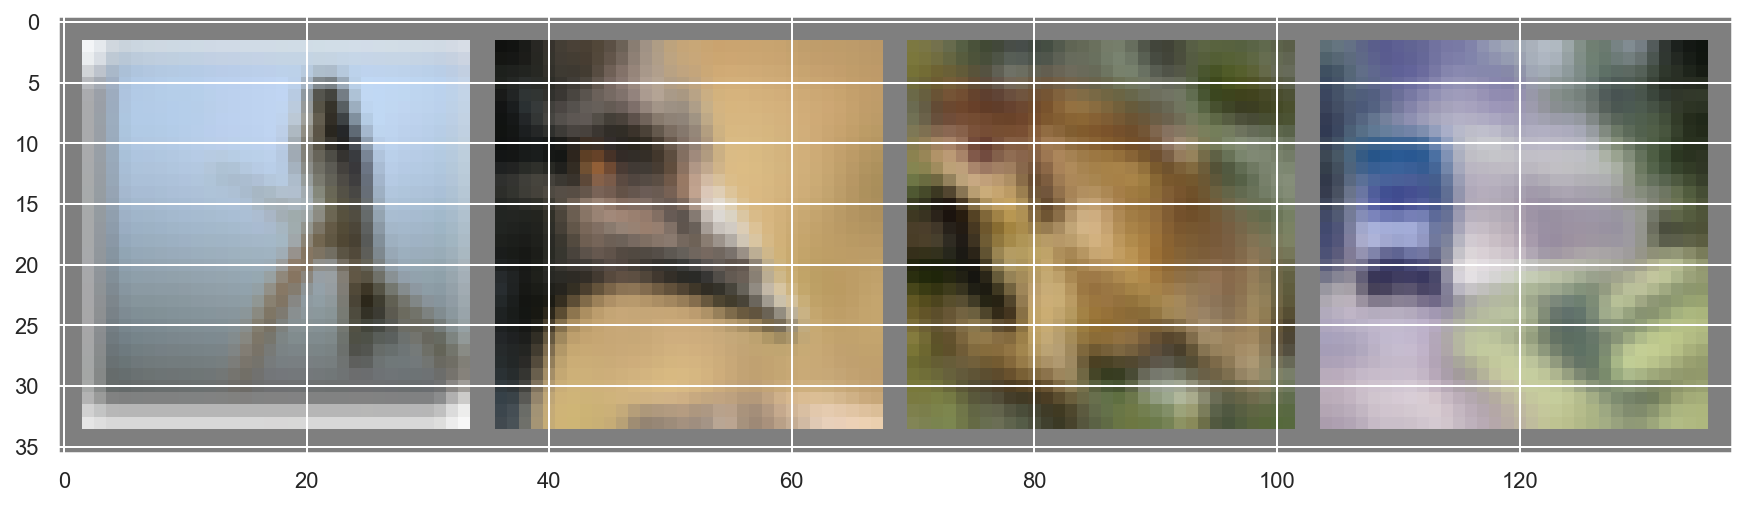

In [118]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

imshow(torchvision.utils.make_grid(transforms.functional.autocontrast(images[:4])))

imshow(torchvision.utils.make_grid(transforms.functional.adjust_sharpness(images[:4], 1.5)))

imshow(torchvision.utils.make_grid(transforms.functional.vflip(images[:4])))

imshow(torchvision.utils.make_grid(transforms.functional.gaussian_blur(images[:4], kernel_size=3)))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [113]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

criterion = nn.CrossEntropyLoss()
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


Training 0/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 0/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.4832116857961066, train acc: 0.47150039174719244
 val loss: 1.2960599353972901, val acc: 0.5348182624113476



Training 1/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 1/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.182543483360158, train acc: 0.5852050143640638
 val loss: 1.1299212470967719, val acc: 0.6055851063829787



Training 2/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 2/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.0568351336981305, train acc: 0.6305334290937582
 val loss: 1.051331756723688, val acc: 0.6375



Training 3/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 3/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 0.9960647418250549, train acc: 0.6536832397492818
 val loss: 0.9922698429290284, val acc: 0.661325354609929



Training 4/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 4/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.9560255433349331, train acc: 0.6686675698615827
 val loss: 0.9935926741742073, val acc: 0.6514849290780141



Training 5/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 5/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.9214607084908912, train acc: 0.6808443784277879
 val loss: 0.9259085743985278, val acc: 0.6770833333333333



Training 6/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 6/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.9022716026637411, train acc: 0.6895770762601201
 val loss: 0.9632234050872478, val acc: 0.6659131205673758



Training 7/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 7/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.8888059479118048, train acc: 0.6910787738312876
 val loss: 0.8954061812542854, val acc: 0.6899157801418438



Training 8/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 8/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.8733351503037448, train acc: 0.6971712588143119
 val loss: 0.903415621341543, val acc: 0.6913785460992907



Training 9/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 9/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.853998936562913, train acc: 0.7032923086967877
 val loss: 0.869898847696629, val acc: 0.7036347517730497



Training 10/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 10/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.765547473208342, train acc: 0.7366846761556542
 val loss: 0.8023129223509038, val acc: 0.7271719858156029



Training 11/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 11/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.7513593051180761, train acc: 0.7421977017498042
 val loss: 0.795149648316363, val acc: 0.7275709219858156



Training 12/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 12/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.7448847475827721, train acc: 0.7431852311308436
 val loss: 0.7913761074238636, val acc: 0.7305186170212766



Training 13/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 13/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.7380375407186679, train acc: 0.7451358056933925
 val loss: 0.7822843347458129, val acc: 0.7330452127659575



Training 14/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 14/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.7367181503903495, train acc: 0.7470945416557848
 val loss: 0.7916470054616319, val acc: 0.7271054964539008



Training 15/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 15/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.7237589008411498, train acc: 0.7517955079655263
 val loss: 0.7791174878465369, val acc: 0.735793439716312



Training 16/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 16/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.7208480089630461, train acc: 0.7517057325672499
 val loss: 0.7757760537431595, val acc: 0.7331338652482269



Training 17/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 17/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.7218997694783499, train acc: 0.7526565356489945
 val loss: 0.7779573171696764, val acc: 0.7343085106382978



Training 18/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 18/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.7192857808125303, train acc: 0.7544887699138155
 val loss: 0.7763040236970211, val acc: 0.7349955673758864



Training 19/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 19/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.7214059519702382, train acc: 0.7508691890833116
 val loss: 0.7773554618054248, val acc: 0.7340647163120566



Посчитайте точность на тестовой выборке:

In [114]:
test(net, criterion, test_loader, 'Testing')[1:2]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

(0.7251194267515924,)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

Рассмотрим качества 2х траснформеров, которые упоминались на лекции: `RandomAdjustSharpness` и `GaussianBlur`

### RandomAdjustSharpness

RandomAdjustSharpness изменяет резкость изображения. При `sharpness_factor` == 1 мы получим начальное изображение, при `sharpness_factor` > 1 - увеличение контрастности, при `sharpness_factor` < 1 - уменьшение. 

In [119]:
transform = transforms.Compose(
        [transforms.RandomAdjustSharpness(sharpness_factor=1.5),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

criterion = nn.CrossEntropyLoss()
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


Training 0/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 0/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.4698860426271638, train acc: 0.48031062287803605
 val loss: 1.22133261776985, val acc: 0.5580673758865248



Training 1/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 1/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.1509401522563187, train acc: 0.5960555954557326
 val loss: 1.0783797733327176, val acc: 0.6260195035460993



Training 2/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 2/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.0454139880549973, train acc: 0.6372257769652651
 val loss: 1.0724578355221037, val acc: 0.6328900709219859



Training 3/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 3/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 0.9874047952988466, train acc: 0.6565886980934971
 val loss: 0.9846934513842805, val acc: 0.6568262411347519



Training 4/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 4/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.9437941194016494, train acc: 0.672132084095064
 val loss: 0.9511549708691049, val acc: 0.6687278368794327



Training 5/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 5/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.9132562194707406, train acc: 0.6834397035779578
 val loss: 0.9607428943857234, val acc: 0.6619459219858157



Training 6/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 6/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.8890055975922718, train acc: 0.6915113280229825
 val loss: 0.9236819107481774, val acc: 0.679188829787234



Training 7/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 7/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.8740761317108405, train acc: 0.6948166949595194
 val loss: 0.9321317302419784, val acc: 0.6797650709219859



Training 8/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 8/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.8552647916228941, train acc: 0.704141094280491
 val loss: 0.9348443424448054, val acc: 0.6810505319148936



Training 9/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 9/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.836113393252249, train acc: 0.7093154217811439
 val loss: 0.86493268051046, val acc: 0.7041445035460993



Training 10/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 10/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.7325314581394196, train acc: 0.7453194371898667
 val loss: 0.8147776161102538, val acc: 0.7208333333333332



Training 11/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 11/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.7158159792859115, train acc: 0.7522158200574562
 val loss: 0.8138737549173071, val acc: 0.7178191489361702



Training 12/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 12/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.7114698489143818, train acc: 0.755419169495952
 val loss: 0.8105542558304807, val acc: 0.7203679078014184



Training 13/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 13/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.7054560321776479, train acc: 0.7573493405588927
 val loss: 0.8088594577413925, val acc: 0.7238696808510638



Training 14/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 14/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.7037161642607213, train acc: 0.7568433337686079
 val loss: 0.8109037836815448, val acc: 0.7243129432624115



Training 15/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 15/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.6884766641656921, train acc: 0.7641967550274223
 val loss: 0.8001579647368573, val acc: 0.7258643617021276



Training 16/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 16/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.6855557663349172, train acc: 0.7643110146252285
 val loss: 0.7985884960661543, val acc: 0.7288563829787233



Training 17/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 17/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.6842846275465579, train acc: 0.7643763058239749
 val loss: 0.7990213434746924, val acc: 0.7252881205673758



Training 18/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 18/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.6836813975404777, train acc: 0.7650904283102637
 val loss: 0.7987181337589914, val acc: 0.7283687943262412



Training 19/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 19/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.683548288001003, train acc: 0.765098589710107
 val loss: 0.7999779393064215, val acc: 0.7245345744680851



In [120]:
test(net, criterion, test_loader, 'Testing')[1:2]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

(0.7161624203821656,)

### GaussianBlur

GaussianBlur размывает изображение. kernel_size - размер матрицы "размывания"

In [121]:
transform = transforms.Compose(
        [transforms.GaussianBlur(kernel_size=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

criterion = nn.CrossEntropyLoss()
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


Training 0/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 0/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.547036360343152, train acc: 0.44818327239488115
 val loss: 1.3716887088532144, val acc: 0.5082225177304964



Training 1/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 1/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.2830582495363365, train acc: 0.5467444176025072
 val loss: 1.1862780215892386, val acc: 0.5787234042553191



Training 2/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 2/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.1779302283440474, train acc: 0.5889347740924523
 val loss: 1.1516716366118573, val acc: 0.6031693262411348



Training 3/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 3/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.1210086485149655, train acc: 0.6062491838600157
 val loss: 1.1088211980271847, val acc: 0.6165336879432625



Training 4/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 4/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 1.0814572330802625, train acc: 0.6225311765474014
 val loss: 1.1100776319808148, val acc: 0.6153368794326242



Training 5/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 5/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 1.0507873183412568, train acc: 0.6304314115957168
 val loss: 1.1012190385067717, val acc: 0.6156693262411348



Training 6/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 6/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 1.0329273073939127, train acc: 0.6397354074170802
 val loss: 1.0199618775793846, val acc: 0.6458554964539008



Training 7/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 7/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 1.0153958173077111, train acc: 0.6461257834943849
 val loss: 1.0503621418425377, val acc: 0.6322916666666667



Training 8/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 8/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 1.0005103491342047, train acc: 0.6511205601984853
 val loss: 1.0618720095208352, val acc: 0.6300531914893617



Training 9/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 9/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.9752867585780198, train acc: 0.6596737072342649
 val loss: 0.9983995691258857, val acc: 0.656781914893617



Training 10/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 10/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.8711403243284557, train acc: 0.6978853813006006
 val loss: 0.9428020340331057, val acc: 0.672052304964539



Training 11/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 11/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.8559395218680066, train acc: 0.7034310524941239
 val loss: 0.9423368758343635, val acc: 0.6700797872340426



Training 12/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 12/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.8528156486464157, train acc: 0.7053530621572212
 val loss: 0.9399624073759039, val acc: 0.673049645390071



Training 13/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 13/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.8456922842554027, train acc: 0.7082462784016714
 val loss: 0.9358796900891243, val acc: 0.6728280141843971



Training 14/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 14/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.8455398787201214, train acc: 0.7049735570645077
 val loss: 0.9331883930145426, val acc: 0.6758200354609928



Training 15/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 15/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.827401745580886, train acc: 0.7161261099503786
 val loss: 0.9252637140294339, val acc: 0.674002659574468



Training 16/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 16/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.8280227002321693, train acc: 0.7128248237137633
 val loss: 0.9236444442830187, val acc: 0.6751551418439715



Training 17/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 17/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.8244600523760376, train acc: 0.7144040545834422
 val loss: 0.9227931103807815, val acc: 0.6799202127659575



Training 18/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 18/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.825306656591635, train acc: 0.716097545050927
 val loss: 0.9250681364789922, val acc: 0.6771719858156029



Training 19/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 19/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.8243242350204335, train acc: 0.7149712718725516
 val loss: 0.9264887160443245, val acc: 0.6779255319148936



In [122]:
test(net, criterion, test_loader, 'Testing')[1:2]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

(0.6831210191082803,)

мда...

Попробуем обучить модель с `RandomHorizontalFlip` + `RandomAdjustSharpness`

In [124]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomAdjustSharpness(sharpness_factor=1.5),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

criterion = nn.CrossEntropyLoss()
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, criterion, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


Training 0/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 0/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.4657707808222589, train acc: 0.4785640833115696
 val loss: 1.2753155206112152, val acc: 0.539738475177305



Training 1/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 1/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.1420756438968387, train acc: 0.6021848067380517
 val loss: 1.0693316868010987, val acc: 0.6265070921985817



Training 2/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 2/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.0505593874554748, train acc: 0.6337775855314703
 val loss: 1.0541243274161156, val acc: 0.6379654255319149



Training 3/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 3/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.0023964556305238, train acc: 0.653634271350222
 val loss: 0.9858560090369367, val acc: 0.6618351063829787



Training 4/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 4/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.9640608527978551, train acc: 0.6665578480020894
 val loss: 1.012594752362434, val acc: 0.6476950354609928



Training 5/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 5/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.9357011710485985, train acc: 0.6750048968399059
 val loss: 0.9678122391092017, val acc: 0.6619680851063829



Training 6/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 6/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.9143099928141948, train acc: 0.683109166884304
 val loss: 0.9300828165196358, val acc: 0.6775930851063829



Training 7/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 7/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.9031516393643193, train acc: 0.6906543810394359
 val loss: 0.9311978020566575, val acc: 0.6813164893617021



Training 8/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 8/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.8927622184674963, train acc: 0.6916133455210237
 val loss: 0.9146214312695442, val acc: 0.6825797872340426



Training 9/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 9/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.8685774819506588, train acc: 0.7000481522590755
 val loss: 0.8993634051464974, val acc: 0.6945478723404256



Training 10/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 10/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.7784148868738624, train acc: 0.7312165382606425
 val loss: 0.8116272713275666, val acc: 0.7205895390070923



Training 11/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 11/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.7639818301584429, train acc: 0.7376722055366937
 val loss: 0.8073677795998594, val acc: 0.7237145390070923



Training 12/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 12/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.758839009285409, train acc: 0.7382231000261165
 val loss: 0.804738483276773, val acc: 0.7253324468085106



Training 13/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 13/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.7501676121839004, train acc: 0.743132182031862
 val loss: 0.7968469880996867, val acc: 0.7261303191489362



Training 14/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 14/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.7483181928367894, train acc: 0.7420385544528597
 val loss: 0.7971022548827719, val acc: 0.7253767730496454



Training 15/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 15/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.7385799333425936, train acc: 0.7462498367720032
 val loss: 0.7874559602838882, val acc: 0.7289007092198583



Training 16/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 16/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.7352084129013571, train acc: 0.7468496996604858
 val loss: 0.7896093672894416, val acc: 0.7284574468085107



Training 17/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 17/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.7321313481771096, train acc: 0.7484656568294594
 val loss: 0.7842050355799655, val acc: 0.7277260638297872



Training 18/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 18/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.7317903597568464, train acc: 0.747604629145991
 val loss: 0.7888466862922019, val acc: 0.7291001773049646



Training 19/20:   0%|          | 0/547 [00:00<?, ?it/s]

Testing 19/20:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.7306770780404699, train acc: 0.7485023831287542
 val loss: 0.7910275630494381, val acc: 0.7273936170212766



In [125]:
test(net, criterion, test_loader, 'Testing')[1:2]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

(0.7269108280254777,)

Ну мы получили небольшое улучшение относительно простого `RandomHorizontalFlip`

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>